In [21]:
%matplotlib inline

from matplotlib import pyplot as pl
import daft
import pymc3 as pm
import numpy as np

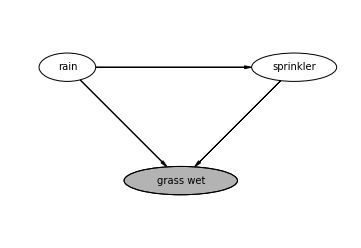

In [13]:
pgm = daft.PGM([6, 4], origin=[2, 1])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 7, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 5, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

Using some observations about whether it has rained, whether the sprinkler has been on, and whether the grass is wet, fit the conditional probability table values for the Bayesian network [above](https://en.wikipedia.org/wiki/Bayesian_network#Example).

In [35]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1])
sprinkler_on = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])
grass_wet =    np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    # conditional probability for s
    sprinkrain = pm.Uniform('sprinkrain', 0., 1.)
    sprinknorain = pm.Uniform('sprinknorain', 0., 1.)
    
    psprinkrain = pm.Bernoulli('psprinkrain', sprinkrain,
                               observed=[has_rained & sprinkler_on])
    psprinknorain = pm.Bernoulli('psprinknorain', sprinknorain,
                                 observed=[sprinkler_on & ~has_rained])

    wetsprinkrain = pm.Uniform('wetsprinkrain', 0., 1.)
    wetsprinknorain = pm.Uniform('wetsprinknorain', 0., 1.)
    wetnosprinkrain = pm.Uniform('wetnosprinkrain', 0., 1.)
    wetnosprinknorain = pm.Uniform('wetnosprinknorain', 0., 1.)
    
    pwetsprinkrain = pm.Bernoulli('pwetsprinkrain', wetsprinkrain,
                                  observed=[grass_wet & sprinkler_on & has_rained])
    pwetsprinknorain = pm.Bernoulli('pwetsprinknorain', wetsprinknorain,
                                    observed=[grass_wet & sprinkler_on & ~has_rained])
    pwetnosprinkrain = pm.Bernoulli('pwetnosprinkrain', wetnosprinkrain,
                                    observed=[grass_wet & has_rained & ~sprinkler_on])
    pwetnosprinknorain = pm.Bernoulli('pwetnosprinknorain', wetnosprinknorain,
                                      observed=[grass_wet & ~has_rained & ~sprinkler_on])
    
    trace = pm.sample(5000, tune=2000, discard_tuned_samples=True, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [wetnosprinknorain, wetnosprinkrain, wetsprinknorain, wetsprinkrain, sprinknorain, sprinkrain, prain]
100%|██████████| 7000/7000 [24:13<00:00,  4.28it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
np.array(has_rained) & np.array(sprinkler_on)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

(array([519., 675., 867., 989., 864., 511., 231.,  96.,  83., 165.]),
 array([0.02154307, 0.11403209, 0.20652111, 0.29901013, 0.39149915,
        0.48398817, 0.57647718, 0.6689662 , 0.76145522, 0.85394424,
        0.94643326]),
 <a list of 10 Patch objects>)

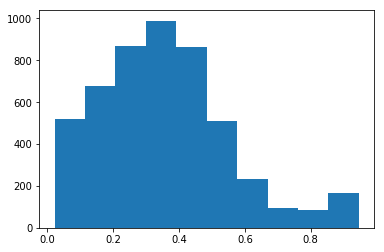

In [38]:
pl.hist(trace['wetnosprinknorain'])

In [24]:
np.sum(has_rained)/len(has_rained)

0.5